In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from pylab import rcParams
import os
import warnings
import scipy.signal as signal
warnings.filterwarnings('ignore')
from datetime import datetime
rcParams['figure.figsize'] = 12,4
rcParams['savefig.dpi'] = 300
from detecta import detect_onset, detect_peaks

logo_path = 'logo/'
now = datetime.now().strftime('%Y%m%d')


def lowpass_filter(data, sr, cut_off, order):
    nyq = 0.5 * sr
    b, a = signal.butter(order, cut_off/nyq, btype = 'low')
    lp_df = signal.filtfilt(b, a, data)
    return lp_df

- 앞으로 기울기 : +
- 투수 쪽으로 기울기 : +
- 투수 쪽으로 돌리기 : +

- 파일 저장 형태 : 이름_트라이얼_왼쪽오른쪽_몸무게_키_타구속도_타구거리_발사각

In [2]:
day = '20240106'

file_list = [i.replace('\\','/') for i in sorted(glob(f'players/{day}/**/**/raw/*csv'))]
right_list = [i for i in file_list if 'right' in i]
left_list = [i for i in file_list if 'left' in i]

In [3]:
for file in file_list:
    df = pd.read_csv(file,sep=',',skiprows=3)
    cut = np.where(df.Activity == 'Pause')[0]
    print(f"{file} : {len(cut)}")

players/20240106/left/Kimjieon/raw/2024-01-06-14-51_Kimjieon_20240106.csv : 12
players/20240106/left/Kwonhyukchan/raw/2024-01-06-15-04_Kwonhyukchan_20240106.csv : 11
players/20240106/right/Jeonseongwoo/raw/2024-01-06-14-31_Jeonseongwoo_20240106.csv : 12
players/20240106/right/Leejinyong/raw/2024-01-06-14-20_Leejinyong_20240106.csv : 12


### 선수 정보 입력

In [4]:
weights = {
    'Leejinyong'  : 77,
    'Jeonseongwoo': 82,
    'Kimjieon'    : 81,
    'Kwonhyukchan': 118,
     }

heights = {
    'Leejinyong'  : 182,
    'Jeonseongwoo': 177,
    'Kimjieon'    : 173,
    'Kwonhyukchan': 189,
     }


# 트라이얼에 맞게 순서대로 입력 필요
ball_vels = {
    'Leejinyong': [
                   0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0,
                   0
                   ],
    'Jeonseongwoo': [
                   0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0,
                   0
                   ],
    'Kimjieon': [
                   0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0,
                   0
                   ],
    'Kwonhyukchan': [
                   0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0,
                   ],
     }    

launch_angs = {
    'Leejinyong': [
                   0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0,
                   0
                   ],
    'Jeonseongwoo': [
                   0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0,
                   0
                   ],
    'Kimjieon': [
                   0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0,
                   0
                   ],
    'Kwonhyukchan': [
                   0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0,
                   ],
     }    

ball_dis = {
    'Leejinyong': [
                   0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0,
                   0
                   ],
    'Jeonseongwoo': [
                   0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0,
                   0
                   ],
    'Kimjieon': [
                   0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0,
                   0
                   ],
    'Kwonhyukchan': [
                   0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0,
                   ],
     }    

In [5]:
sr = 1000

new_cols = [
            'lead_force_x','lead_force_y','lead_force_z',
            'rear_force_x','rear_force_y','rear_force_z',
            'lead_moment_z','rear_moment_z',
            'pelvic_angular_velo','torso_angular_velo','upperarm_angular_velo','forearm_angular_velo',
            'pelvic_forward_tilt','pelvic_lateral_tilt','pelvic_rotation',
            'torso_forward_tilt','torso_lateral_tilt','torso_rotation',
            'x_factor',
            'shoulder_rotation','shoulder_horizontal_adduction','elbow_flexion',
            # 'acc_result'
            ]

new_ang_cols = ['pelvic_forward_tilt','pelvic_lateral_tilt','pelvic_rotation',
            'torso_forward_tilt','torso_lateral_tilt','torso_rotation',
            'x_factor',
            'shoulder_rotation','shoulder_horizontal_abduction','elbow_flexion']

new_ks_cols = {'pelvic_angular_velo' : ['Pelvic', 'r'],
               'torso_angular_velo' : ['Torso', 'g'],
               'upperarm_angular_velo' : ['Upper Arm','b'],
               'forearm_angular_velo' : ['Forearm','y']}

force_cols = ['LT Force plate Fx (N)','LT Force plate Fy (N)','LT Force plate Fz (N)',
              'RT Force plate Fx (N)','RT Force plate Fy (N)','RT Force plate Fz (N)']

moment_cols = ['LT Force plate Mz (N*m)','RT Force plate Mz (N*m)']

In [6]:
data = {
    'right' : {},
    'left' : {}
    }

for file in file_list:
    df = pd.read_csv(file,sep=',',skiprows=3)
    name = file.split('/')[3]
    weight = weights[name]
    height = heights[name]
    
    if file in right_list:
        acc_cols = ['LT Forearm Accel Sensor X (mG)','LT Forearm Accel Sensor Y (mG)','LT Forearm Accel Sensor Z (mG)']
        ks_cols = [
            'Noraxon MyoMotion-Segments-Pelvis-Gyroscope-z (deg/s)',
            'Noraxon MyoMotion-Segments-Upper spine-Gyroscope-z (deg/s)',
            'Noraxon MyoMotion-Segments-Upper arm LT-Gyroscope-z (deg/s)',
            'Noraxon MyoMotion-Segments-Forearm LT-Gyroscope-z (deg/s)'
                ]
        ang_cols = [
            'Noraxon MyoMotion-Segments-Pelvis-Tilt Fwd (deg)','Noraxon MyoMotion-Segments-Pelvis-RT Tilt Lat (deg)','Noraxon MyoMotion-Segments-Pelvis-LT Rotation (deg)',
            'Noraxon MyoMotion-Segments-Lower spine-Tilt Fwd (deg)','Noraxon MyoMotion-Segments-Lower spine-RT Tilt Lat (deg)','Noraxon MyoMotion-Segments-Lower spine-LT Rotation (deg)',
            'LT Torso-Pelvic Axial (deg)',
            'LT Shoulder Rotation Ext (deg)','Noraxon MyoMotion-Joints-Shoulder LT-Adduction Hrz (deg)',
            'LT Elbow Flexion (deg)'
        ]

        all_cols = [
            *force_cols,*moment_cols,*ks_cols,*ang_cols
            # ,*acc_cols        
                    ]
        
        
        cut = np.where(df.Activity == 'Pause')[0]
        for i in range(len(cut)-1):
            d = df.iloc[cut[i]:cut[i+1]].reset_index(drop=True)
            d = d[all_cols]
            
            # for col in acc_cols:
            #     d[col] = lowpass_filter(d[col], 1000, 13.4, 4)
            for col in force_cols:
                d[col] = lowpass_filter(d[col], 1000, 40, 4)
            for col in moment_cols:
                d[col] = lowpass_filter(d[col], 1000, 40, 4)
            for col in ks_cols:
                d[col] = lowpass_filter(d[col], 1000, 13.4, 4)
                               
            # d['acc_result'] = np.sqrt(d[acc_cols[0]]**2 + d[acc_cols[1]]**2 + d[acc_cols[2]]**2)
            # del d[acc_cols[0]]; del d[acc_cols[1]]; del d[acc_cols[2]]
            d[force_cols] = 100 * (d[force_cols] / 9.81) / weight
            
            d.columns = new_cols
            d['rear_force_y'] = - d['rear_force_y']
            d['weight'] = weight
            d['height'] = height
            d['ball_vel'] = ball_vels[name][i]
            d['launch_ang'] = launch_angs[name][i]
            d['ball_dis'] = ball_dis[name][i]
            # d.to_csv(f'players/right/{name}/process/{name}_{str(i+1).zfill(3)}.csv',index=False)
            data['right'][f"{name}_{str(i+1).zfill(3)}_R_{weight}_{height}_{ball_vels[name][i]}_{ball_dis[name][i]}_{launch_angs[name][i]}"] = d
        
    elif file in left_list:
        acc_cols = ['RT Forearm Accel Sensor X (mG)','RT Forearm Accel Sensor Y (mG)','RT Forearm Accel Sensor Z (mG)']
        ks_cols = [
            'Noraxon MyoMotion-Segments-Pelvis-Gyroscope-z (deg/s)',
            'Noraxon MyoMotion-Segments-Upper spine-Gyroscope-z (deg/s)',
            'Noraxon MyoMotion-Segments-Upper arm RT-Gyroscope-z (deg/s)',
            'Noraxon MyoMotion-Segments-Forearm RT-Gyroscope-z (deg/s)'
                ]

        ang_cols = [
            'Noraxon MyoMotion-Segments-Pelvis-Tilt Fwd (deg)','Noraxon MyoMotion-Segments-Pelvis-LT Tilt Lat (deg)','Noraxon MyoMotion-Segments-Pelvis-RT Rotation (deg)',
            'Noraxon MyoMotion-Segments-Lower spine-Tilt Fwd (deg)','Noraxon MyoMotion-Segments-Lower spine-LT Tilt Lat (deg)','Noraxon MyoMotion-Segments-Lower spine-RT Rotation (deg)',
            'RT Torso-Pelvic Axial (deg)',
            'RT Shoulder Rotation Ext (deg)','Noraxon MyoMotion-Joints-Shoulder RT-Adduction Hrz (deg)',
            'RT Elbow Flexion (deg)'
        ]
        all_cols = [*force_cols,*moment_cols,*ks_cols,*ang_cols
                    # ,*acc_cols
                    ]
        
        cut = np.where(df.Activity == 'Pause')[0]
        for i in range(len(cut)-1):
            d = df.iloc[cut[i]:cut[i+1]].reset_index(drop=True)
            d = d[all_cols]

            # for col in acc_cols:
            #     d[col] = lowpass_filter(d[col], 1000, 13.4, 4)
            for col in force_cols:
                d[col] = lowpass_filter(d[col], 1000, 40, 4)
            for col in moment_cols:
                d[col] = lowpass_filter(d[col], 1000, 40, 4)
            for col in ks_cols:
                d[col] = lowpass_filter(d[col], 1000, 13.4, 4)
            
            # d['acc_result'] = np.sqrt(d[acc_cols[0]]**2 + d[acc_cols[1]]**2 + d[acc_cols[2]]**2)
            # del d[acc_cols[0]]; del d[acc_cols[1]]; del d[acc_cols[2]]
            
            d[ks_cols] = - d[ks_cols]
            d[force_cols] = 100 * (d[force_cols] / 9.81) / weight
            d.columns = new_cols
            d['weight'] = weight
            d['height'] = height
            d['ball_vel'] = ball_vels[name][i]
            d['launch_ang'] = launch_angs[name][i]
            d['ball_dis'] = ball_dis[name][i]
            
            d[['lead_moment_z','rear_moment_z']] = - d[['lead_moment_z','rear_moment_z']]
            
            # d.to_csv(f'players/left/{name}/process/{name}_{str(i+1).zfill(3)}.csv', index=False)
            data['left'][f"{name}_{str(i+1).zfill(3)}_L_{weight}_{height}_{ball_vels[name][i]}_{ball_dis[name][i]}_{launch_angs[name][i]}"] = d

In [7]:
da = {}
wrong = {}
plot = False
for side in ['right','left']:
    for trial in data[side]:
        r = data[side][trial]
        # print(trial)
        try:
            toe_off_time = detect_onset(r['lead_force_z'],threshold=1,n_above= sr * 0.1,n_below=sr*0.1, show=plot)[-2][-1]
            df = r.iloc[toe_off_time-500:].reset_index(drop=True)
            
            lead_leg_result_grf = np.sqrt(df['lead_force_y']**2 + df['lead_force_z']**2)
            fc_10_time = detect_onset(df['lead_force_z'],threshold=10,n_above= sr * 0.2,n_below=sr*0.5, show=plot)[-1][0]
            lead_max_grf = detect_peaks(lead_leg_result_grf,mph=100,mpd=sr*1,show=plot)
            peak_hand_time, bc_time = detect_peaks(df['forearm_angular_velo'],mph=500,mpd=sr*0.02,show=plot)
            lead_max_grf = [i for i in lead_max_grf if fc_10_time < i < bc_time][0]
            
            fc_100_time = [i for i in detect_onset(df['lead_force_z'],threshold=100,n_above= sr * 0.1,n_below=sr*0.5, show=plot)[:,0] if fc_10_time < i < lead_max_grf][0]
            lead_max_grf_y = detect_peaks(df['lead_force_y'], mph=40, mpd = sr*0.02, show=plot)[0]
            # print(fc_10_time, lead_max_grf, peak_hand_time, bc_time, lead_max_grf_y)
            if fc_10_time > lead_max_grf:
                print('fc_time 시점이 lead_max_grf 보다 뒤에 나타남')
                wrong[trial]= r
            if lead_max_grf > bc_time:
                print('lead_max_grf 시점이 bc_time 보다 뒤에 나타남')
                wrong[trial]= r
                
            df = df.iloc[:bc_time+500]
            t = np.arange(0,len(df)/sr,1/sr)
            df['time'] = t
            df['to_time'] = 500
            df['fc_10_time'] = fc_10_time
            df['fc_100_time'] = fc_100_time
            df['lead_max_grf_time'] = lead_max_grf
            df['bc_time'] = bc_time
            df['peak_hand_time'] = peak_hand_time
            df['peak_lead_grf_y'] = lead_max_grf_y
            plus = df['shoulder_rotation'][0]
            df['shoulder_rotation'] = np.cumsum(df['upperarm_angular_velo']) * (1/1000) + plus
            df['shoulder_horizontal_adduction'] = lowpass_filter(df['shoulder_horizontal_adduction'], 1000, 13.4, 4)
            
            da[trial] = df
            df.to_csv(f"players/{day}/{side}/{trial.split('_')[0]}/process/{trial}.csv", index=False)
        
        except Exception:
            print(f"{trial} 에서 시점 오류 발생")
            wrong[trial] = r

Jeonseongwoo_007_R_82_177_0_0_0 에서 시점 오류 발생
Jeonseongwoo_008_R_82_177_0_0_0 에서 시점 오류 발생
Jeonseongwoo_011_R_82_177_0_0_0 에서 시점 오류 발생
Leejinyong_001_R_77_182_0_0_0 에서 시점 오류 발생
Leejinyong_004_R_77_182_0_0_0 에서 시점 오류 발생
Leejinyong_005_R_77_182_0_0_0 에서 시점 오류 발생
Leejinyong_007_R_77_182_0_0_0 에서 시점 오류 발생
Leejinyong_010_R_77_182_0_0_0 에서 시점 오류 발생
Leejinyong_011_R_77_182_0_0_0 에서 시점 오류 발생
Kimjieon_001_L_81_173_0_0_0 에서 시점 오류 발생
Kimjieon_002_L_81_173_0_0_0 에서 시점 오류 발생
Kimjieon_006_L_81_173_0_0_0 에서 시점 오류 발생
Kimjieon_008_L_81_173_0_0_0 에서 시점 오류 발생
Kimjieon_011_L_81_173_0_0_0 에서 시점 오류 발생
Kwonhyukchan_007_L_118_189_0_0_0 에서 시점 오류 발생
Kwonhyukchan_008_L_118_189_0_0_0 에서 시점 오류 발생


In [8]:
plot = False
wrong1= {}
for trial in wrong:
    r = wrong[trial]
    n, tri, s, _, _, _, _, _ = trial.split('_')
    if s == 'L':
        side = 'left'
    elif s == 'R':
        side = 'right'
        
    try:
        # print(trial)
        toe_off_time = detect_onset(r['lead_force_z'],threshold=1,n_above= sr * 0.1,n_below=sr*0.1, show=plot)[-3][-1]
        df = r.iloc[toe_off_time-500:].reset_index(drop=True)
        
        lead_leg_result_grf = np.sqrt(df['lead_force_y']**2 + df['lead_force_z']**2)
        fc_10_time = detect_onset(df['lead_force_z'],threshold=10,n_above= sr * 0.2,n_below=sr*0.6, show=plot)[-1][0]
        lead_max_grf = detect_peaks(lead_leg_result_grf,mph=100,mpd=sr*1,show=plot)
        
        peak_hand_time, bc_time = detect_peaks(df['forearm_angular_velo'],mph=500,mpd=sr*0.02,show=plot)
        lead_max_grf = [i for i in lead_max_grf if fc_10_time < i < bc_time][0]
        fc_100_time = [i for i in detect_onset(df['lead_force_z'],threshold=100,n_above= sr * 0.1,n_below=sr*0.5, show=plot)[:,0] if fc_10_time < i < lead_max_grf][0]
        lead_max_grf_y = detect_peaks(df['lead_force_y'], mph=40, mpd = sr*0.02, show=plot)[0]
        # print(fc_10_time, lead_max_grf, peak_hand_time, bc_time, lead_max_grf_y)
        if fc_10_time > lead_max_grf:
            print('fc_time 시점이 lead_max_grf 보다 뒤에 나타남')
            wrong[trial]= r
        if lead_max_grf > bc_time:
            print('lead_max_grf 시점이 bc_time 보다 뒤에 나타남')
            wrong[trial]= r
            
        df = df.iloc[:bc_time+500]
        t = np.arange(0,len(df)/sr,1/sr)
        df['time'] = t
        df['to_time'] = 500
        df['fc_10_time'] = fc_10_time
        df['fc_100_time'] = fc_100_time
        df['lead_max_grf_time'] = lead_max_grf
        df['bc_time'] = bc_time
        df['peak_hand_time'] = peak_hand_time
        df['peak_lead_grf_y'] = lead_max_grf_y
        plus = df['shoulder_rotation'][0]
        df['shoulder_rotation'] = np.cumsum(df['upperarm_angular_velo']) * (1/1000) + plus
        df['shoulder_horizontal_adduction'] = lowpass_filter(df['shoulder_horizontal_adduction'], 1000, 13.4, 4)
        
        da[trial] = df
        df.to_csv(f"players/{day}/{side}/{trial.split('_')[0]}/process/{trial}.csv", index=False)
    except Exception:
        print(f"{trial} 에서 시점 오류 발생")
        wrong1[trial] = r

Leejinyong_004_R_77_182_0_0_0 에서 시점 오류 발생
Kimjieon_008_L_81_173_0_0_0 에서 시점 오류 발생
Kimjieon_011_L_81_173_0_0_0 에서 시점 오류 발생


In [9]:
plot = False
wrong2= {}
for trial in wrong1:
    r = wrong1[trial]
    n, tri, s, _, _, _, _, _ = trial.split('_')
    if s == 'L':
        side = 'left'
    elif s == 'R':
        side = 'right'
        
    try:
        # print(trial)
        toe_off_time = detect_onset(r['lead_force_z'],threshold=1,n_above= sr * 0.1,n_below=sr*0.1, show=plot)[-4][-1]
        df = r.iloc[toe_off_time-500:].reset_index(drop=True)
        
        lead_leg_result_grf = np.sqrt(df['lead_force_y']**2 + df['lead_force_z']**2)
        fc_10_time = detect_onset(df['lead_force_z'],threshold=10,n_above= sr * 0.2,n_below=sr*0.6, show=plot)[-1][0]
        lead_max_grf = detect_peaks(lead_leg_result_grf,mph=100,mpd=sr*1,show=plot)
        
        peak_hand_time, bc_time = detect_peaks(df['forearm_angular_velo'],mph=500,mpd=sr*0.02,show=plot)
        lead_max_grf = [i for i in lead_max_grf if fc_10_time < i < bc_time][0]
        
        fc_100_time = [i for i in detect_onset(df['lead_force_z'],threshold=100,n_above= sr * 0.1,n_below=sr*0.5, show=plot)[:,0] if fc_10_time < i < lead_max_grf][0]
        lead_max_grf_y = detect_peaks(df['lead_force_y'], mph=40, mpd = sr*0.02, show=plot)[0]
        # print(fc_10_time, lead_max_grf, peak_hand_time, bc_time, lead_max_grf_y)
        if fc_10_time > lead_max_grf:
            print('fc_time 시점이 lead_max_grf 보다 뒤에 나타남')
            wrong[trial]= r
        if lead_max_grf > bc_time:
            print('lead_max_grf 시점이 bc_time 보다 뒤에 나타남')
            wrong[trial]= r
            
        df = df.iloc[:bc_time+500]
        t = np.arange(0,len(df)/sr,1/sr)
        df['time'] = t
        df['to_time'] = 500
        df['fc_10_time'] = fc_10_time
        df['fc_100_time'] = fc_100_time
        df['lead_max_grf_time'] = lead_max_grf
        df['bc_time'] = bc_time
        df['peak_hand_time'] = peak_hand_time
        df['peak_lead_grf_y'] = lead_max_grf_y
        plus = df['shoulder_rotation'][0]
        df['shoulder_rotation'] = np.cumsum(df['upperarm_angular_velo']) * (1/1000) + plus
        df['shoulder_horizontal_adduction'] = lowpass_filter(df['shoulder_horizontal_adduction'], 1000, 13.4, 4)
        
        da[trial] = df
        df.to_csv(f"players/{day}/{side}/{trial.split('_')[0]}/process/{trial}.csv", index=False)
    except Exception:
        print(f"{trial} 에서 시점 오류 발생")
        wrong2[trial] = r

Kimjieon_011_L_81_173_0_0_0 에서 시점 오류 발생


In [10]:
wrong2.keys()

dict_keys(['Kimjieon_011_L_81_173_0_0_0'])

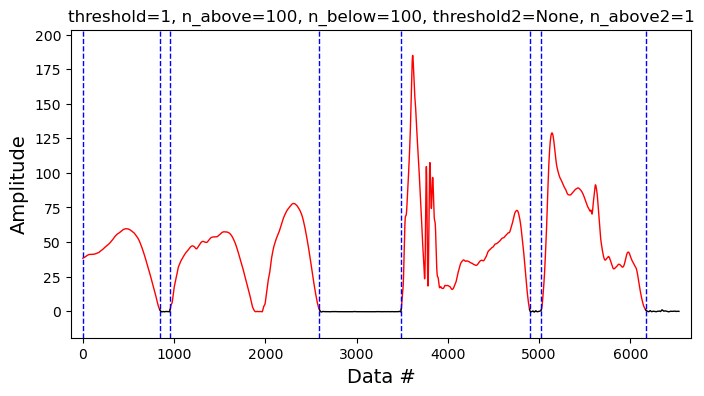

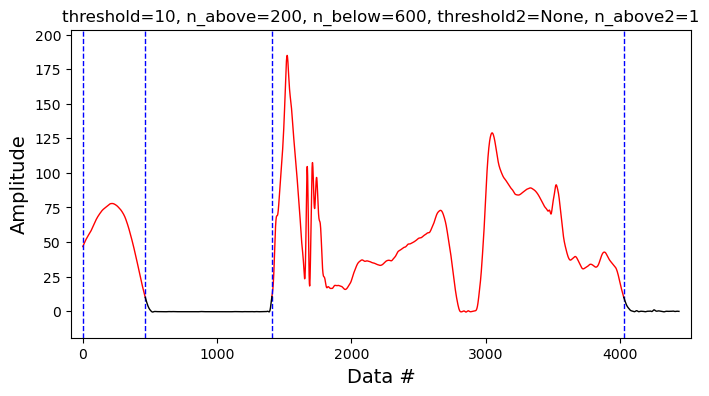

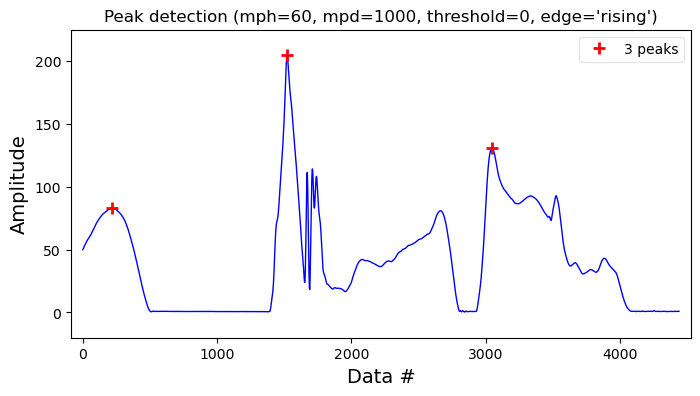

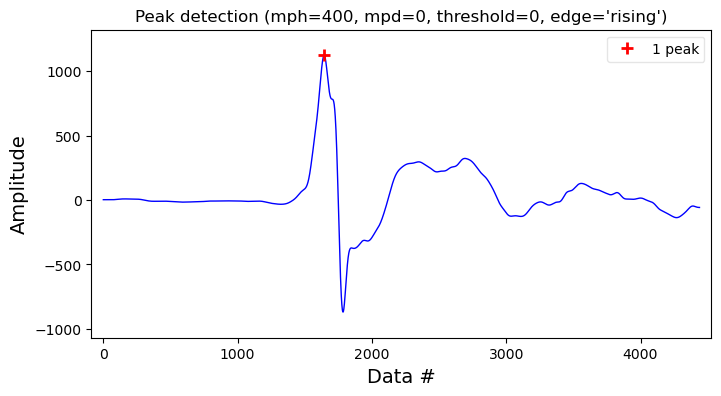

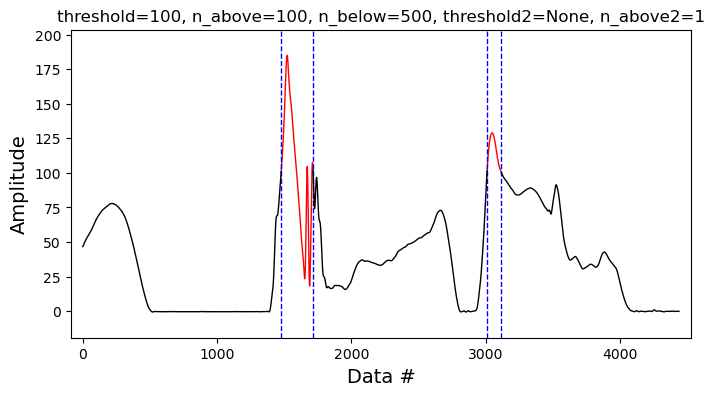

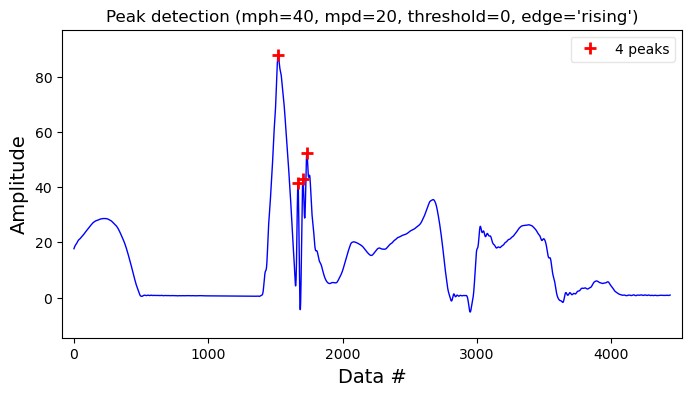

1408 1521 1644 1644 1521


In [11]:
plot = True
trial = 'Kimjieon_011_L_81_173_0_0_0'
n, tri, s, _, _, _, _, _ = trial.split('_')
r = wrong2[trial]
toe_off_time = detect_onset(r['lead_force_z'],threshold=1,n_above= sr * 0.1,n_below=sr*0.1, show=plot)[-3][-1]
df = r.iloc[toe_off_time-500:].reset_index(drop=True)
lead_leg_result_grf = np.sqrt(df['lead_force_y']**2 + df['lead_force_z']**2)
fc_10_time = detect_onset(df['lead_force_z'],threshold=10,n_above= sr * 0.2,n_below=sr*0.6, show=plot)[-1][0]
lead_max_grf = detect_peaks(lead_leg_result_grf,mph=60,mpd=sr*1,show=plot)

peak_hand_time = detect_peaks(df['forearm_angular_velo'],mph=400,mpd=0,show=plot)[0]
bc_time = peak_hand_time
lead_max_grf = [i for i in lead_max_grf if fc_10_time < i < bc_time][0]
fc_100_time = [i for i in detect_onset(df['lead_force_z'],threshold=100,n_above= sr * 0.1,n_below=sr*0.5, show=plot)[:,0] if fc_10_time < i < lead_max_grf]
lead_max_grf_y = detect_peaks(df['lead_force_y'], mph=40, mpd = sr*0.02, show=plot)[0]
df = df.iloc[:bc_time+500]
t = np.arange(0,len(df)/sr,1/sr)
df['time'] = t
df['to_time'] = 500
df['fc_10_time'] = fc_10_time
df['fc_100_time'] = fc_100_time[0]
df['lead_max_grf_time'] = lead_max_grf
df['bc_time'] = bc_time
df['peak_hand_time'] = peak_hand_time
df['peak_lead_grf_y'] = lead_max_grf_y
plus = df['shoulder_rotation'][0]
df['shoulder_rotation'] = np.cumsum(df['upperarm_angular_velo']) * (1/1000) + plus
df['shoulder_horizontal_adduction'] = lowpass_filter(df['shoulder_horizontal_adduction'], 1000, 13.4, 4)
da[trial] = df
df.to_csv(f"players/{day}/{side}/{trial.split('_')[0]}/process/{trial}.csv", index=False)
print(fc_10_time, lead_max_grf, peak_hand_time, bc_time, lead_max_grf_y)

In [12]:
df = da['Jeonseongwoo_006_R_82_177_0_0_0']
df1 = da['Kimjieon_001_L_81_173_0_0_0']

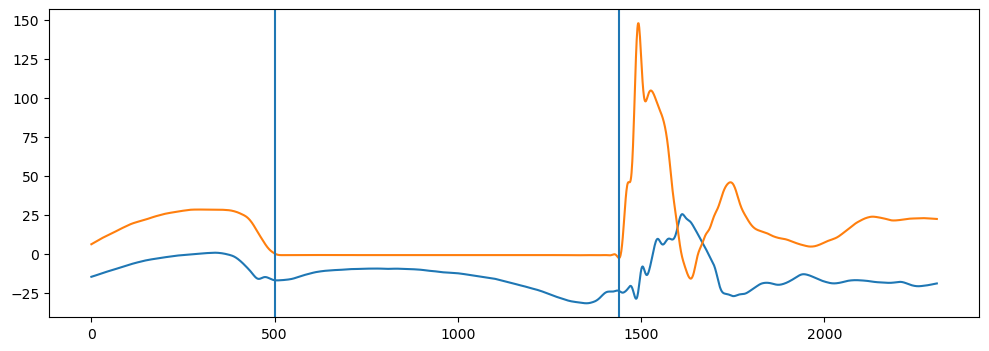

In [13]:
plt.plot(df['rear_force_x'])
plt.plot(df['lead_force_y'])
plt.axvline(df['fc_10_time'][0])
plt.axvline(df['to_time'][0])

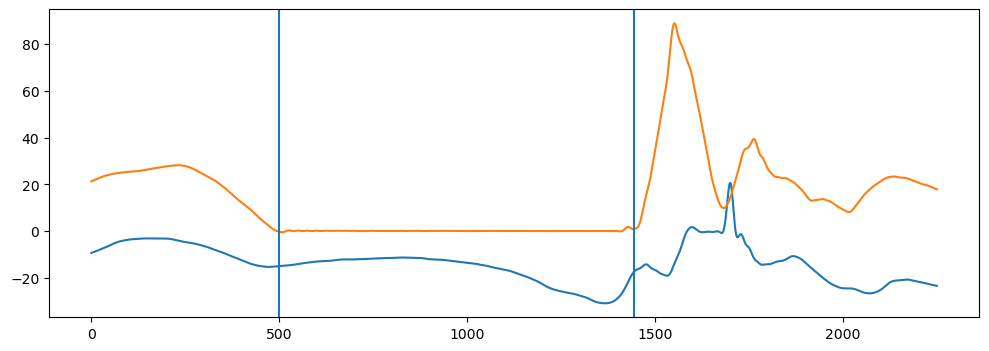

In [14]:
plt.plot(df1['rear_force_x'])
plt.plot(df1['lead_force_y'])
plt.axvline(df1['fc_10_time'][0])
plt.axvline(df1['to_time'][0])

In [13]:
# for trial in da:
#     df = da[trial]
#     plt.plot(df['shoulder_rotation'])
#     plt.plot(df['shoulder_rotation_1'])
#     plt.title(trial)
#     plt.show()

In [2]:
# fig, ax = plt.subplots()
# t = df['time']
# for col in new_ks_cols:
#     plt.plot(t, np.array(df[col]),color = new_ks_cols[col][-1],label=new_ks_cols[col][0])

# plt.ylabel('Angular Velocity [Deg/s]')
# plt.xlabel('Time [s]')
# plt.autoscale(axis='x', tight=True)
# plt.axvline(t[df['to_time'][0]], color='k',linestyle = '--',alpha=0.5)
# plt.axvline(t[df['fc_10_time'][0]], color='k',linestyle = '--',alpha=0.5)
# plt.axvline(t[df['lead_max_grf_time'][0]], color='k',linestyle = '--',alpha=0.5)
# plt.axvline(t[df['bc_time'][0]], color='k',linestyle = '--',alpha=0.5)
# plt.axhline(0,color='k',lw=0.9)  
# plt.text(t[df['to_time'][0]],y = df['forearm_angular_velo'].max(), s='Toe Off',rotation = 90,verticalalignment='top',horizontalalignment='right')
# plt.text(t[df['fc_10_time'][0]],y = df['forearm_angular_velo'].max(), s='Foot Contact',rotation = 90,verticalalignment='top',horizontalalignment='right')
# plt.text(t[df['lead_max_grf_time'][0]],y = df['forearm_angular_velo'].max(), s='Max GRF',rotation = 90,verticalalignment='top',horizontalalignment='right')
# plt.text(t[df['bc_time'][0]], y=df['forearm_angular_velo'].max(),s='Ball Contact', rotation=90,verticalalignment='top',horizontalalignment='right')
# plt.legend()
# plt.tight_layout()
# plt.title('KINEMATIC SEQUENCE')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.grid(axis='y')
# plt.show()

In [3]:
# for col in new_cols:
#     plt.plot(t, np.array(df[col]), color = 'firebrick')
#     plt.title(col)

#     plt.autoscale(axis='x', tight=True)
#     plt.axvline(t[df['to_time'][0]], color='k',linestyle = '--',alpha=0.5)
#     plt.axvline(t[df['fc_10_time'][0]], color='k',linestyle = '--',alpha=0.5)
#     plt.axvline(t[df['lead_max_grf_time'][0]], color='k',linestyle = '--',alpha=0.5)
#     plt.axvline(t[df['bc_time'][0]], color='k',linestyle = '--',alpha=0.5)
#     plt.axhline(0,color='k',lw=0.9)  
#     plt.text(t[df['to_time'][0]],y = df[col].max(), s='Toe Off',rotation = 90,verticalalignment='top',horizontalalignment='right')
#     plt.text(t[df['fc_10_time'][0]],y = df[col].max(), s='Foot Contact',rotation = 90,verticalalignment='top',horizontalalignment='right')
#     plt.text(t[df['lead_max_grf_time'][0]],y = df[col].max(), s='Max GRF',rotation = 90,verticalalignment='top',horizontalalignment='right')
#     plt.text(t[df['bc_time'][0]], y=df[col].max() ,s='Ball Contact', rotation=90,verticalalignment='top',horizontalalignment='right')
#     plt.show()